In [1]:
#! pip install yellowbrick
#!pip install threadpoolctl

In [2]:
#!pip install scikit-learn==1.1.3

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from scipy.cluster.hierarchy import cophenet, linkage, dendrogram

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("./Group_7_data_cleaned.csv")

In [5]:
df.drop(columns=['Date','Time'], inplace=True)

In [6]:
df.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.77,0,0,1
1,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.65,0,0,1
2,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.52,0,0,1
3,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.39,0,0,1
4,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.25,0,0,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   S1_Temp               10129 non-null  float64
 1   S2_Temp               10129 non-null  float64
 2   S3_Temp               10129 non-null  float64
 3   S4_Temp               10129 non-null  float64
 4   S1_Light              10129 non-null  int64  
 5   S2_Light              10129 non-null  int64  
 6   S3_Light              10129 non-null  int64  
 7   S4_Light              10129 non-null  int64  
 8   S1_Sound              10129 non-null  float64
 9   S2_Sound              10129 non-null  float64
 10  S3_Sound              10129 non-null  float64
 11  S4_Sound              10129 non-null  float64
 12  S5_CO2                10129 non-null  int64  
 13  S5_CO2_Slope          10129 non-null  float64
 14  S6_PIR                10129 non-null  int64  
 15  S7_PIR             

In [8]:
df_wo_light = df.drop(df.filter(regex='Light').columns, axis=1)

In [9]:
df_wo_light.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,24.75,24.56,25.38,0.08,0.19,0.06,0.06,390,0.77,0,0,1
1,24.94,24.75,24.56,25.44,0.93,0.05,0.06,0.06,390,0.65,0,0,1
2,25.00,24.75,24.50,25.44,0.43,0.11,0.08,0.06,390,0.52,0,0,1
3,25.00,24.75,24.56,25.44,0.41,0.10,0.10,0.09,390,0.39,0,0,1
4,25.00,24.75,24.56,25.44,0.18,0.06,0.06,0.06,390,0.25,0,0,1


In [10]:
X_wo_light = df_wo_light.drop(['Room_Occupancy_Count'], axis=1)
y_wo_light = df_wo_light[['Room_Occupancy_Count']]

In [11]:
# Scaling the dataset
scaler = StandardScaler()
X_scaled_wo_light = scaler.fit_transform(X_wo_light)

In [12]:
X_scaled_wo_light_df = pd.DataFrame(X_scaled_wo_light, index=X_wo_light.index, columns=X_wo_light.columns)
X_scaled_wo_light_df.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR
0,-1.463033,-1.357775,-1.162334,-1.049684,-0.278432,0.262426,-0.237223,-0.363288,-0.354382,0.665096,-0.314749,-0.294029
1,-1.463033,-1.357775,-1.162334,-0.881342,2.405552,-0.262923,-0.237223,-0.363288,-0.354382,0.562090,-0.314749,-0.294029
2,-1.292255,-1.357775,-1.302764,-0.881342,0.826738,-0.037773,-0.188869,-0.363288,-0.354382,0.450500,-0.314749,-0.294029
3,-1.292255,-1.357775,-1.162334,-0.881342,0.763585,-0.075298,-0.140515,-0.114690,-0.354382,0.338910,-0.314749,-0.294029
4,-1.292255,-1.357775,-1.162334,-0.881342,0.037331,-0.225398,-0.237223,-0.363288,-0.354382,0.218737,-0.314749,-0.294029


### Using Kmeans to perform clustering on the dataset

In [13]:
km = KMeans(n_clusters=3)
km.fit(X_scaled_wo_light_df)

KMeans(n_clusters=3)

In [14]:
km.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [15]:
cluster = km.predict(X_scaled_wo_light_df)
cluster

array([1, 1, 1, ..., 1, 1, 1])

In [16]:
X_scaled_wo_light_df['Cluster'] = cluster
X_scaled_wo_light_df.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Cluster
0,-1.463033,-1.357775,-1.162334,-1.049684,-0.278432,0.262426,-0.237223,-0.363288,-0.354382,0.665096,-0.314749,-0.294029,1
1,-1.463033,-1.357775,-1.162334,-0.881342,2.405552,-0.262923,-0.237223,-0.363288,-0.354382,0.562090,-0.314749,-0.294029,1
2,-1.292255,-1.357775,-1.302764,-0.881342,0.826738,-0.037773,-0.188869,-0.363288,-0.354382,0.450500,-0.314749,-0.294029,1
3,-1.292255,-1.357775,-1.162334,-0.881342,0.763585,-0.075298,-0.140515,-0.114690,-0.354382,0.338910,-0.314749,-0.294029,1
4,-1.292255,-1.357775,-1.162334,-0.881342,0.037331,-0.225398,-0.237223,-0.363288,-0.354382,0.218737,-0.314749,-0.294029,1


In [17]:
X_scaled_wo_light_df['Cluster'].value_counts()

1    7547
0    1697
2     885
Name: Cluster, dtype: int64

In [18]:
km.cluster_centers_

array([[ 1.41540356,  1.16540909,  1.31707913,  1.14142855,  0.05779885,
        -0.01756232, -0.07544933, -0.16029827,  1.35949782, -0.51472382,
         0.03917233, -0.01096592],
       [-0.5109087 , -0.45618679, -0.47298676, -0.40057985, -0.25389704,
        -0.24433194, -0.22754512, -0.18662014, -0.489681  , -0.0585804 ,
        -0.27403256, -0.28766379],
       [ 1.6428114 ,  1.65552824,  1.50796359,  1.22731288,  2.05432355,
         2.11726152,  2.08510794,  1.89881171,  1.56898833,  1.48654533,
         2.26174945,  2.4741331 ]])

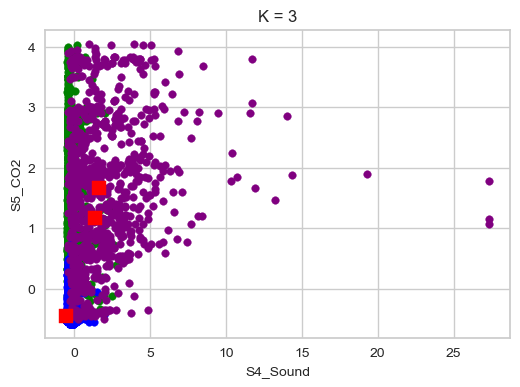

In [19]:
labels = [0, 1, 2]
colors = ["green", "blue", "purple"]
plt.figure(figsize=(6,4))
for label, color in zip(labels, colors):
    index = X_scaled_wo_light_df["Cluster"]==label
    plt.scatter(X_scaled_wo_light_df.loc[index, "S4_Sound"],
                X_scaled_wo_light_df.loc[index, "S5_CO2"],
                c = color,
                s=30)

plt.xlabel("S4_Sound", fontsize = 10)
plt.ylabel("S5_CO2", fontsize = 10)
plt.title("K = 3", fontsize = 12)

plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color="red", marker="s", s=100);

In [20]:
km.inertia_

59003.72627632347

In [21]:
silhouette_score(X_scaled_wo_light, km.labels_)

0.5426368548119108

SilhouetteVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=3))

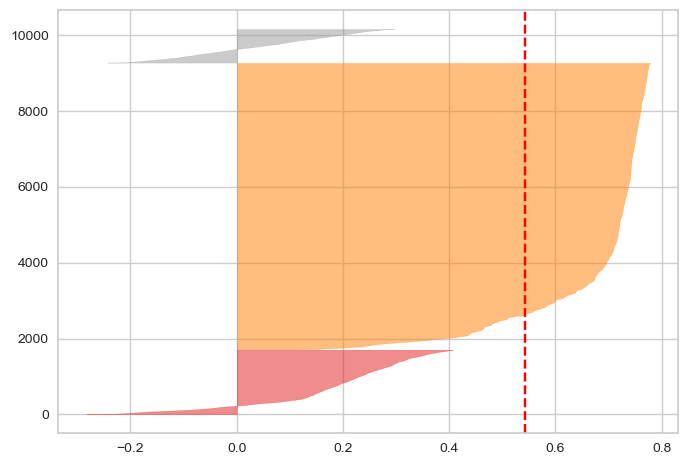

In [22]:
visualizer = SilhouetteVisualizer(km)
visualizer.fit(X_scaled_wo_light)

## Finding the optimum number of clusters for KMeans

### 1. Using Elbow Method

To find the optimal value of "K", we plot the Inertia against the number of clusters and find the "elbow" in the plot where increasing the value of K will not significantly reduce the model's inertia. 

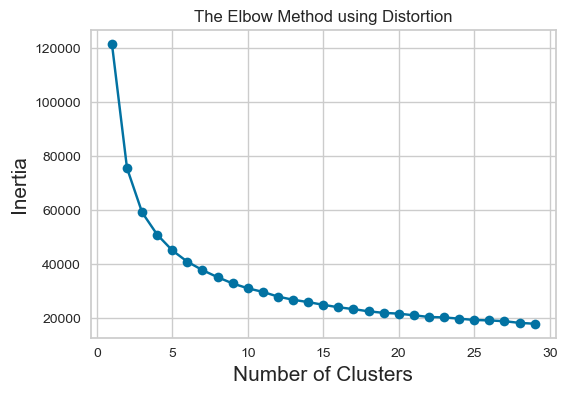

In [23]:
inertia = []
plt.figure(figsize=(6,4))
for i in range(1,30):
    km = KMeans(n_clusters=i)
    km.fit(X_scaled_wo_light)
    inertia.append(km.inertia_)
    
plt.plot(range(1,30), inertia, marker='o')
plt.xlabel('Number of Clusters', fontsize=15)
plt.ylabel('Inertia', fontsize=15)
plt.title('The Elbow Method using Distortion')
plt.show();

The "elbow" part of the plot seems to be around 3 to 5 clusters, after which the inertia seems to decrease very gradually. To further narrow the optimal number of clusters we can look at the silhouette scores of each number of clusters.

### 2. Silhouette Score

With the help of the silhouette score, we can assess the quality of clustering for each number of clusters. The silhouette coefficient is the measure of how similar a data observation is to its own cluster (cohesion) compared to other clusters (separation). The silhouette coefficient can vary from -1 to +1. A value close to +1 indicates that the data point is well inside its own cluster and far from other clusters, and a value close to -1 indicates that the data point may have been assigned to the wrong cluster.

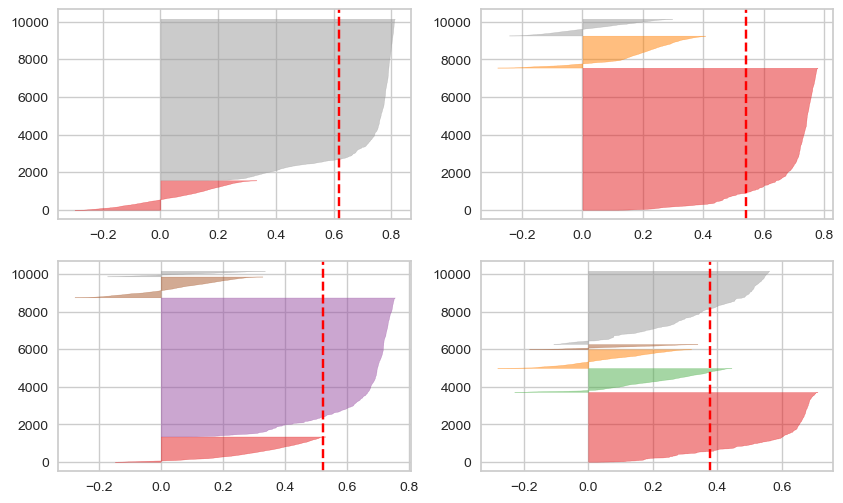

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
for k in range(2,6):
    km = KMeans(n_clusters=k)
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, ax=ax[q-1][mod])
    visualizer.fit(X_scaled_wo_light)

From both the methods we can see that when the number of cluster is 4 we have a low inertia and a high silhouette score.

### Performing KMeans with optimal number of clusters

Silhouette Score when K=4 0.5242477660154924


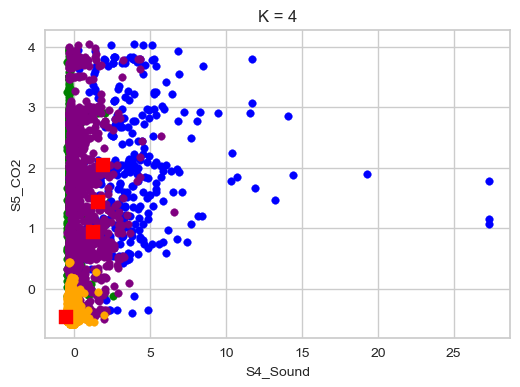

In [32]:
X_scaled_wo_light_df_1 = pd.DataFrame(X_scaled_wo_light, index=X_wo_light.index, columns=X_wo_light.columns)
X_scaled_wo_light_df_1.head()

km = KMeans(n_clusters=4)
km.fit(X_scaled_wo_light_df_1)

cluster = km.predict(X_scaled_wo_light_df_1)
print("Silhouette Score when K=4", silhouette_score(X_scaled_wo_light_df_1, km.labels_))
X_scaled_wo_light_df_1['Cluster'] = cluster

labels = [0, 1, 2, 3]
colors = ["green", "blue", "purple", "orange"]

plt.figure(figsize=(6,4))

for label, color in zip(labels, colors):
    index = X_scaled_wo_light_df_1["Cluster"]==label
    plt.scatter(X_scaled_wo_light_df_1.loc[index, "S4_Sound"],
                X_scaled_wo_light_df_1.loc[index, "S5_CO2"],
                c = color,
                s=30)

plt.xlabel("S4_Sound", fontsize = 10)
plt.ylabel("S5_CO2", fontsize = 10)
plt.title("K = 4", fontsize = 12)

plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color="red", marker="s", s=100);